
<font size = "5"> **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# Basic Crystallography
[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM//main/Diffraction/CH2_03-Basic_Crystallography.ipynb)
 
[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main//Diffraction/CH2_03-Basic_Crystallography.ipynb)
 
part of

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher and Khalid Hattar, Spring 2024

Microscopy Facilities and Ion Beam Facility<br>
Institute of Advanced Materials & Manufacturing<br>
Materials Science & Engineering and Nuclear Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.



## Load relevant python packages
### Check Installed Packages

In [1]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2024.1.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
if 'google.colab' in sys.modules:
    !{sys.executable} -m pip install numpy==1.24.4
print('done')

done


### Load the plotting and figure packages
Import the python packages that we will use:

Beside the basic numerical (numpy) and plotting (pylab of matplotlib) libraries,
* three dimensional plotting
and some libraries from the book
* kinematic scattering library.

In [1]:
%matplotlib widget
import matplotlib.pylab as plt
import numpy as np
import sys
if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    
# 3D plotting package 
from mpl_toolkits.mplot3d import Axes3D # 3D plotting

import ase

# Import libraries from the pyTEMlib
import pyTEMlib
import pyTEMlib.kinematic_scattering as ks         # kinematic scattering Library
                             # with atomic form factors from Kirkland's book
# it is a good idea to show the version numbers at this point for archiving reasons.
print('pyTEM version: ',pyTEMlib.__version__)

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled
Qt dialogs are not available
Using kinematic_scattering library version {_version_ }  by G.Duscher
pyTEM version:  0.2023.8.0



## Define  Crystal

A crystal is well defined by its unit cell and the atom positions within, the so called base.
The base consists of which element sits where within the unit cell


The unit cell fills the volume completely when translated in all three directions. Placing the unit cell in a global carthesian coordination system, we need the length of the sides and their angles for a complete description. This is depicted in the graph below.
![unitcell_angles](images/unit_cell_angles.png)

Figure taken from the wikipedia page on lattice constants.

Mathematically it is more advantageous to describe the unit cell as matrix, the
### Structure Matrix

This matrix consists of rows of vectors that span the unit cell:
$\begin{bmatrix}
  a_1 & a_2 & a_3 \\
  b_1 & b_2 & b_3 \\
  c_1 & c_2 & c_3 \\
\end{bmatrix} =\left[\vec{a},\vec{b},\vec{c}\right]$.

This structure matrix is also used to describe the super cells in materials simulations for example density functional theory.

The representation of unit cells as structure matrices allows also for easy conversions as we will see in the following.


In [2]:
# Create graphite unit cell (or structure matrix)
a = b = 2.46  # Angstrom
c = 6.71  # Angstrom
gamma = 120
alpha = beta = 90

## Create the structure matrix for a hexagonal system explicitly:
structure_matrix = np.array([[a,0.,0.],  ## also called the structure matrix
                    [np.cos(np.radians(gamma))*a,np.sin(np.radians(gamma))*a,0. ],
                     [0.,0.,c]
                    ])
print('structure matrix \n', np.round(structure_matrix,3))

elements = ['C']*4
base = [[0, 0, 0], [0, 0, 1/2], [1/3, 2/3, 0], [2/3, 1/3, 1/2]]
print('elements:', elements)
print('base \n',np.round(base,3))

structure matrix 
 [[ 2.46  0.    0.  ]
 [-1.23  2.13  0.  ]
 [ 0.    0.    6.71]]
elements: ['C', 'C', 'C', 'C']
base 
 [[0.    0.    0.   ]
 [0.    0.    0.5  ]
 [0.333 0.667 0.   ]
 [0.667 0.333 0.5  ]]


### Store Information in ASE (atomic simulation environment) format

In [3]:
atoms = ase.Atoms(elements, cell=structure_matrix, scaled_positions=base)
atoms

Atoms(symbols='C4', pbc=False, cell=[[2.46, 0.0, 0.0], [-1.2299999999999995, 2.130422493309719, 0.0], [0.0, 0.0, 6.71]])

We can retrieve the information stored

In [4]:
print('structure matrix [nm]\n',np.round(atoms.cell.array,3))
print('elements \n',atoms.get_chemical_formula())
print('base \n',np.round(atoms.get_scaled_positions(), 3))

structure matrix [nm]
 [[ 2.46  0.    0.  ]
 [-1.23  2.13  0.  ]
 [ 0.    0.    6.71]]
elements 
 C4
base 
 [[0.    0.    0.   ]
 [0.    0.    0.5  ]
 [0.333 0.667 0.   ]
 [0.667 0.333 0.5  ]]


A convenient function is provided by the kinematic_scttering library (loaded with name ks)

In [5]:
atoms = ks.structure_by_name('Graphite')
atoms.positions

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.35550000e+00],
       [1.23386207e+00, 7.12370598e-01, 0.00000000e+00],
       [3.04714108e-16, 1.42474120e+00, 3.35550000e+00]])

### Volume of Unit Cell
We will need the volume of the unit cell  for unit conversions later.

Volume of the parallelepiped (https://en.wikipedia.org/wiki/Triple_product) : 
$\vec{a} \cdot \vec{b} \times \vec{c} =  \det \begin{bmatrix}
  a_1 & a_2 & a_3 \\
  b_1 & b_2 & b_3 \\
  c_1 & c_2 & c_3 \\
\end{bmatrix} ={\rm det}\left(\vec{a},\vec{b},\vec{c}\right)$

We see that the structure matrix comes in handy for that calculation.

In [6]:
volume = v = np.linalg.det(structure_matrix)
print(f"volume of unit cell: {volume:.4f} Ang^3")

volume of unit cell: 35.1660 Ang^3


The same procedure is provided by ase

In [7]:
print(f"volume of unit cell: {atoms.cell.volume:.4f} Ang^3")

volume of unit cell: 35.3925 Ang^3


### Vector Algebra in Unit Cell 
We will use the linear algebra package of numpy (np.linalg) for our vector calculations.

The length of a vector is called its norm.

And the angle between two vectors is calculated by the dot product: $\vec{a} \cdot \vec{b} = \left\| \vec{a} \right\| \left\| \vec{b} \right\| \cos (\theta) $

> Note that python starts couting at 0 and so the second vector has index 1

In [8]:
length_b = np.linalg.norm(structure_matrix[1])
print(f'length of second unit cell vector is {length_b:.3f} Ang' ) 

gamma = np.arccos(np.dot(structure_matrix[0]/length_b, structure_matrix[1]/length_b))
print(f'angle between a and b is {np.degrees(gamma):.1f} degree')

length of second unit cell vector is 2.460 Ang
angle between a and b is 120.0 degree


### Plot the unit cell

We use the visualization library of ase to plot structures.

<Axes: >

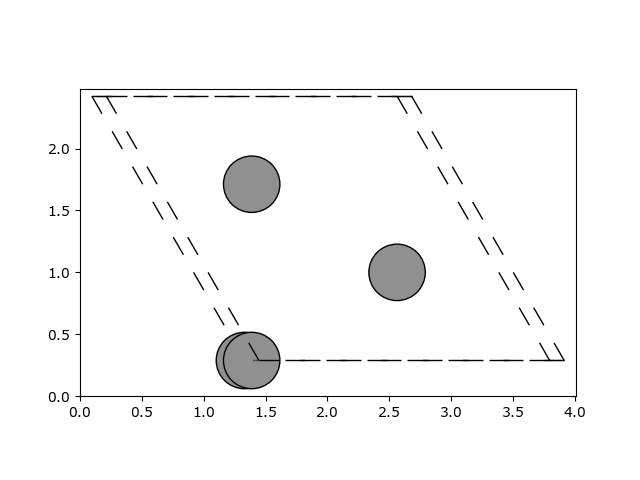

In [9]:
from ase.visualize.plot import plot_atoms

plot_atoms(atoms, radii=0.3, rotation=('0x,1y,0z'))


In [14]:
# This does not work in Google Colab

from ase.visualize import view
view(atoms*(4,4,1))

<Popen: returncode: None args: ['C:\\Users\\gduscher\\AppData\\Local\\anacon...>

In [15]:
from ase.visualize import view
view(atoms*(3,3,1), viewer = 'x3d')

## Reciprocal Lattice 
The unit cell in reciprocal space

In [10]:
reciprocal_lattice = np.linalg.inv(atoms.cell.array).T # transposed of inverted unit_cell

print('reciprocal lattice [1/Ang.]:')
print(np.round(reciprocal_lattice,4))

reciprocal lattice [1/Ang.]:
[[0.4052 0.234  0.    ]
 [0.     0.4679 0.    ]
 [0.     0.     0.149 ]]


The same function is provided in ase package of Cell.

In [17]:
print('reciprocal lattice [1/Ang.]:')
print(np.round(atoms.cell.reciprocal(),4))

reciprocal lattice [1/Ang.]:
[[ 0.4052  0.234   0.    ]
 [-0.      0.4679  0.    ]
 [ 0.      0.      0.149 ]]


### Reciprocal Lattice Vectors
From your crystallography book and lecture you are probably used to the following expression for the reciprocal lattice vectors ($\vec{a}^*, \vec{b}^*, \vec{c}^*$)

$ \begin{align}
  \vec{a}^* &=  \frac{\vec{b} \times \vec{c}}{\vec{a} \cdot \left(\vec{b} \times \vec{c}\right)} \\
  \vec{b}^* &=  \frac{\vec{c} \times \vec{a}}{\vec{b} \cdot \left(\vec{c} \times \vec{a}\right)} \\
  \vec{c}^* &=  \frac{\vec{a} \times \vec{b}}{\vec{c} \cdot \left(\vec{a} \times \vec{b}\right)}
\end{align}$\

Where we see that the denominators of the above vector equations are the volume of the unit cell.

In physics book, you will see an additional factor of 2$\pi$, which is generally omitted in materials science and microscopy.

In [18]:
## Now let's test whether this is really equivalent to the matrix expression above.
a,b,c = atoms.cell

a_recip = np.cross(b, c)/np.dot(a, np.cross(b, c))
print (np.round(a_recip, 3))
b_recip = np.cross(c, a)/np.dot(a, np.cross(b, c))
print (np.round(b_recip, 3))
c_recip = np.cross(a, b)/np.dot(a, np.cross(b, c))
print (np.round(c_recip, 3))

print('Compare to:')
print(np.round(reciprocal_lattice, 3))

[ 0.405  0.234 -0.   ]
[0.    0.468 0.   ]
[ 0.    -0.     0.149]
Compare to:
[[0.405 0.234 0.   ]
 [0.    0.468 0.   ]
 [0.    0.    0.149]]


## Conclusion

With these definitions we have everything to define a crystal and to analyse diffraction and imaging data of crystalline specimens.

Crystallography deals with the application of symmetry and group theory of symmetry to crystal structures.
If you want to play around with symmetry and space groups, you can install the [spglib](http://atztogo.github.io/spglib/python-spglib.html#python-spglib). The spglib is especially helpfull for determination of reduced unit cells (the smallest possible ones, instead of the ones with the full symmetry).

A number of common crystal structures are defined in the kinematic_scattering libary of the pyTEMlib package under the function ''structure_by_name''. Try them out in this notebook.

In [19]:
# As ususal the help function will show you the usage of a function:
help(ks.structure_by_name)

Help on function structure_by_name in module pyTEMlib.crystal_tools:

structure_by_name(crystal_name)
    Provides crystal structure in ase.Atoms format.
    Additional information is stored in the info attribute as a dictionary


    Parameter
    ---------
    crystal_name: str
        Please note that the chemical expressions are not case-sensitive.

    Returns
    -------
    atoms: ase.Atoms
        structure

    Example
    -------
    >> #  for a list of pre-defined crystal structures
    >> import pyTEMlib.crystal_tools
    >> print(pyTEMlib.crystal_tools.crystal_data_base.keys())
    >>
    >> atoms = pyTEMlib.crystal_tools.structure_by_name('Silicon')
    >> print(atoms)
    >> print(atoms.info)



Here are all the predifined crystal structures.

> Check out the [building tutorial of ase](https://wiki.fysik.dtu.dk/ase/ase/build/build.html) for more fun structures like nanotubes 

In [20]:
print(ks.crystal_data_base.keys())

dict_keys(['aluminum', 'al', 'aluminium', 'gold', 'au', 'silver', 'ag', 'copper', 'cu', 'diamond', 'germanium', 'ge', 'silicon', 'si', 'gaas', 'fcc fe', 'iron', 'bcc fe', 'alpha iron', 'srtio3', 'strontium titanate', 'graphite', 'cscl', 'cesium chlorid', 'mgo', 'titanium nitride', 'zno wurzite', 'zno', 'wzno', 'gan', 'gan wurzite', 'wgan', 'gallium nitride', 'tio2', 'mos2', 'ws2', 'wse2', 'mose2', 'zno hexagonal', 'pdse2'])


Now use one name of above structures and redo this notebook

## Navigation

- <font size = "3">  **Back: [Basic Crystallography](CH2_03-Basic_Crystallography.ipynb)** </font>
- <font size = "3">  **Next: [Structure Factors](CH2_04-Structure_Factors.ipynb)** </font>
- <font size = "3">  **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>
- <font size = "3">  **List of Content: [Front](../_MSE672_Intro_TEM.ipynb)** </font>

## Appendix: Read POSCAR

Load and draw a  crystal structure  from a POSCAR file
 

### The function 

In [21]:
from ase.io import read, write
import pyTEMlib.file_tools as ft
import os

def read_poscar(): # open file dialog to select poscar file
    file_name = ft.open_file_dialog_qt('POSCAR (POSCAR*.txt);;All files (*)')
    #use ase package to read file
    
    base = os.path.basename(file_name)
    base_name = os.path.splitext(base)[0]
    crystal = read(file_name, format='vasp', parallel=False)
    
    return crystal

In [22]:
atoms = read_poscar()
atoms

TypeError: expected str, bytes or os.PathLike object, not NoneType